In [0]:
!wget https://proai-datasets.s3.eu-west-3.amazonaws.com/wikipedia.csv

--2024-09-18 17:25:00--  https://proai-datasets.s3.eu-west-3.amazonaws.com/wikipedia.csv
Resolving proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)... 16.12.19.14, 52.95.154.64
Connecting to proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)|16.12.19.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1003477941 (957M) [text/csv]
Saving to: ‘wikipedia.csv’

wikipedia.csv       100%[===================>] 956.99M  19.4MB/s    in 63s     

2024-09-18 17:26:03 (15.2 MB/s) - ‘wikipedia.csv’ saved [1003477941/1003477941]



In [0]:
!pip install wordcloud

  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/40/ad/c22887189c23cc133ae7cbad48c71312f1a962b960fe7f51fd792808a307/wordcloud-1.9.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/548.3 kB ? eta -:--:--
   ━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/548.3 kB 2.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━ 327.7/548.3 kB 5.2 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 542.7/548.3 kB 6.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 542.7/548.3 kB 6.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 542.7/548.3 kB 6.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 542.7/548.3 kB 6.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 542.7/548.3 kB 6.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 542.7/548.3 kB 6.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5

In [0]:
import warnings
import pandas as pd
from pyspark.sql.functions import split, size, avg, max, min, col, udf, concat_ws, collect_list, array_join
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from wordcloud import WordCloud
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.classification import NaiveBayes, LogisticRegression
warnings.filterwarnings('ignore')

In [0]:
dataset = pd.read_csv('/databricks/driver/wikipedia.csv')
spark_df = spark.createDataFrame(dataset)
spark_df = spark_df.drop("Unnamed: 0")
spark_df.write.saveAsTable("wikipedia")

Let's start cleaning our dataframe of empty and duplicate observations.

In [0]:
spark_df = spark_df.filter(
    (col("documents").isNotNull() & (col("documents") != "")) &
    (col("summary").isNotNull() & (col("summary") != ""))
)

In [0]:
spark_df = spark_df.dropDuplicates(["title","summary", "documents","categoria"])

# EDA Analysis 
Let's create a copy of our dataframe dedicated only our EDA activity.

In [0]:
EDA_df = spark_df.select("*")

In [0]:
display(EDA_df)

title summary documents categoria david cooperrider david cooperrider (born july 14, 1954), is the fairmount minerals chair and professor of social entrepreneurship at the weatherhead school of management at case western reserve university, and faculty director at the center for business as an agent of world benefit at case.cooperrider also teaches at university of pennsylvania as well as claremont university, where he is the peter f. drucker distinguished fellow.cooperrider is the founder, together with suresh srivastva, of the theory of appreciative inquiry. cooperrider's original doctoral dissertation "appreciative inquiry into organizational life" has been cited as “the first, and as yet, the best articulation of the theory and vision of appreciative inquiry.” it was completed and defended in 1985. david cooperrider (born july 14, 1954), is the fairmount minerals chair and professor of social entrepreneurship at the weatherhead school of management at case western reserve university, and faculty director at the center for business as an agent of world benefit at case.cooperrider also teaches at university of pennsylvania as well as claremont university, where he is the peter f. drucker distinguished fellow.cooperrider is the founder, together with suresh srivastva, of the theory of appreciative inquiry. cooperrider's original doctoral dissertation "appreciative inquiry into organizational life" has been cited as “the first, and as yet, the best articulation of the theory and vision of appreciative inquiry.” it was completed and defended in 1985. early life and education cooperrider grew up in oak park, illinois, and later completed his undergraduate studies at augustana college in 1976. he earned a master's of science at sir george williams university in 1983 and his ph.d. from case western reserve university in 1985. appreciative inquiry appreciative inquiry was articulated first as a method for building generative theory. it was a call for "a scholarship of the positive," focusing attention on "what gives life" to human and ecological systems when they are most alive. appreciative inquiry is related to theories and practices such as organization development, strengths-based management, applied positive psychology, evaluation studies, change management, coaching and counseling, corporate strategy, sustainable development, social constructionism, design thinking, biomimicry, and learning theory.in a new york times best-selling book, marcus buckingham concluded that the theory of appreciative inquiry was one of the three most important academic catalysts for the strengths revolution in management. beyond the seminal work of cooperrider and srivastva, the other two giant sources of the strengths revolution in management included peter drucker's effective executive and martin seligman's call for a positive psychology in 2000. together, appreciative inquiry, drucker's management theory, and positive psychology have created a society-wide positive-strengths movement "because it works."what is big idea of appreciative inquiry? it began with the observation that ever since taylorism, managers, researchers and consultants have seen organizations not only in machine-like terms, but in deficit-based terms as "problems to be solved" or fixed. true to abraham maslow's observation that "if all you have is a hammer, everything looks like a nail," those same managers and consultants became, over the years, quite good at finding, analyzing, and sometimes solving problems in organizations. so much so that organizations became problems personified—and hence a whole vocabulary of deficit-based change grew up centered on concepts like "gap analysis," "organizational diagnosis," "root causes of failure," "resistance," "unfreezing," "needs analysis," "threat analysis," and the need for high levels of dissatisfaction and urgent "burning platforms." much like diagnostic medicine with its focus on illness, management had become locked in a problem

Since we will have to print some graphs on the screen let's create a function that taken as input the data and the title of the graph then prints everything on the screen.

In [0]:
def create_bar_chart(data, x_column, y_column, title, y_label, figsize=(10, 6)):
    # Convert the data to a pandas DataFrame if it is not already
    if not isinstance(data, pd.DataFrame):
        data = data.toPandas()
    
    categories = data[x_column]
    values = data[y_column]
    
    # Create the colours map
    colormap = cm.get_cmap('Oranges')
    norm = plt.Normalize(values.min(), values.max())
    
    # Create the graph
    plt.figure(figsize=figsize)
    bars = plt.bar(categories, values, color=colormap(norm(values)))
    
    # Add labels above the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')
    
    # Set title and labels
    plt.title(title)
    plt.xlabel(x_column)
    plt.ylabel(y_label)
    
    # Add color bar
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label=y_label)
    
    # Rotate the labels on the x-axis
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

We start calculating for the number of items in each category.

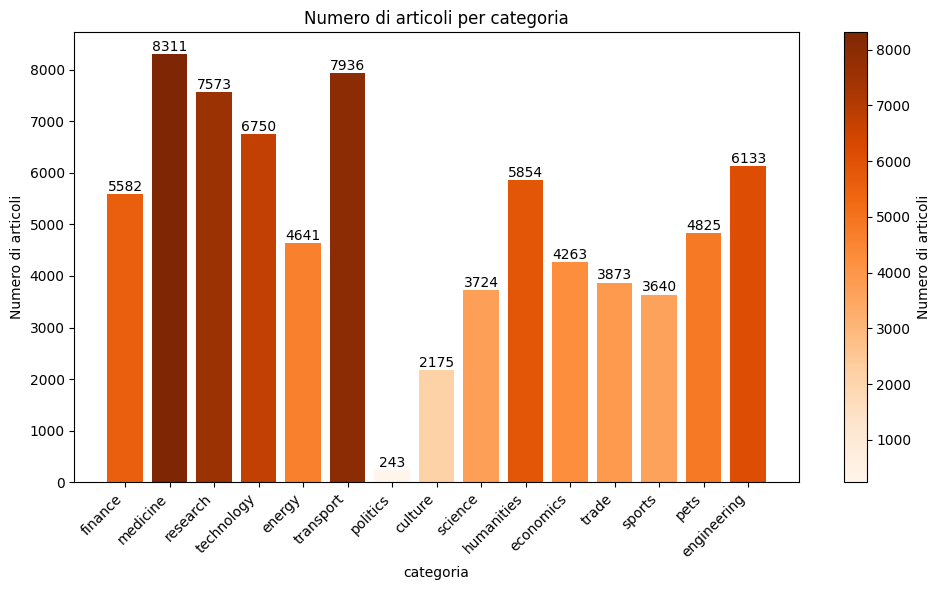

In [0]:
art_num = EDA_df.groupBy("categoria").count()

create_bar_chart(
    data=art_num,
    x_column='categoria',
    y_column='count',
    title='Numero di articoli per categoria',
    y_label='Numero di articoli'
)

Then we continue by calculating the average number of words used per article in each cateogory.

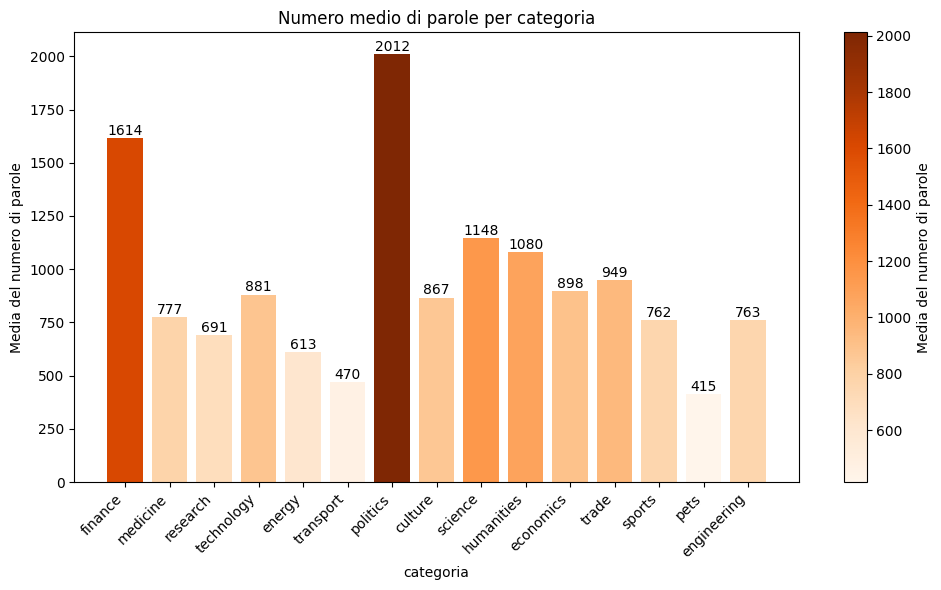

In [0]:
EDA_df = EDA_df.withColumn("words_array", split(col("documents"), " "))
EDA_df = EDA_df.withColumn("num_words", size(col("words_array")))
avg_num_words = EDA_df.groupBy("categoria").agg(avg("num_words").cast("int").alias("avg_num_words"))

create_bar_chart(
    data=avg_num_words,
    x_column='categoria',
    y_column='avg_num_words',
    title='Numero medio di parole per categoria',
    y_label='Media del numero di parole'
)

Then we calculate the maximum number of words in the longest article.

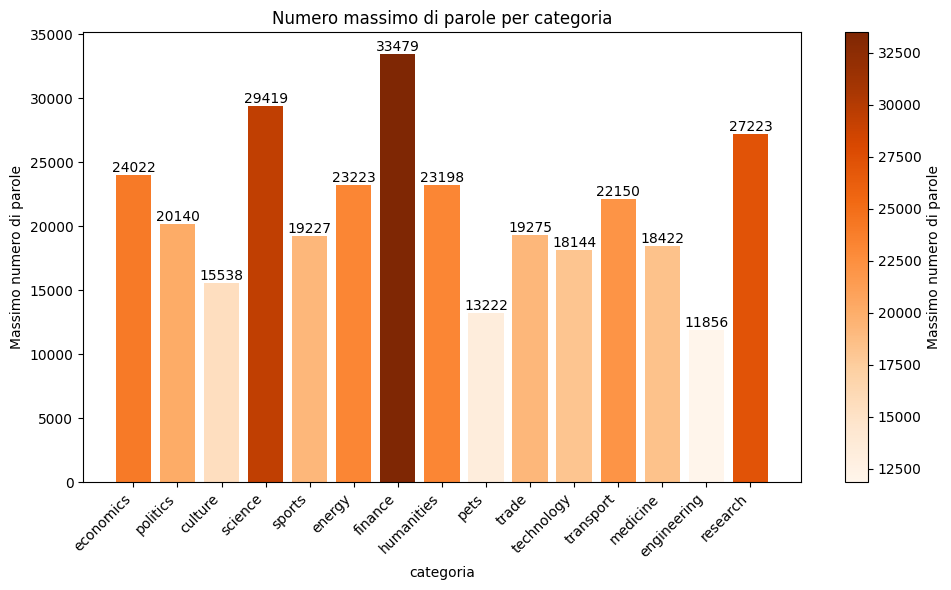

In [0]:
max_num_words = EDA_df.groupBy("categoria").agg(max("num_words").alias("max_num_words"))

create_bar_chart(
    data=max_num_words,
    x_column='categoria',
    y_column='max_num_words',
    title='Numero massimo di parole per categoria',
    y_label='Massimo numero di parole'
)

In the end we calculate the minimum number of words in the shortest article.

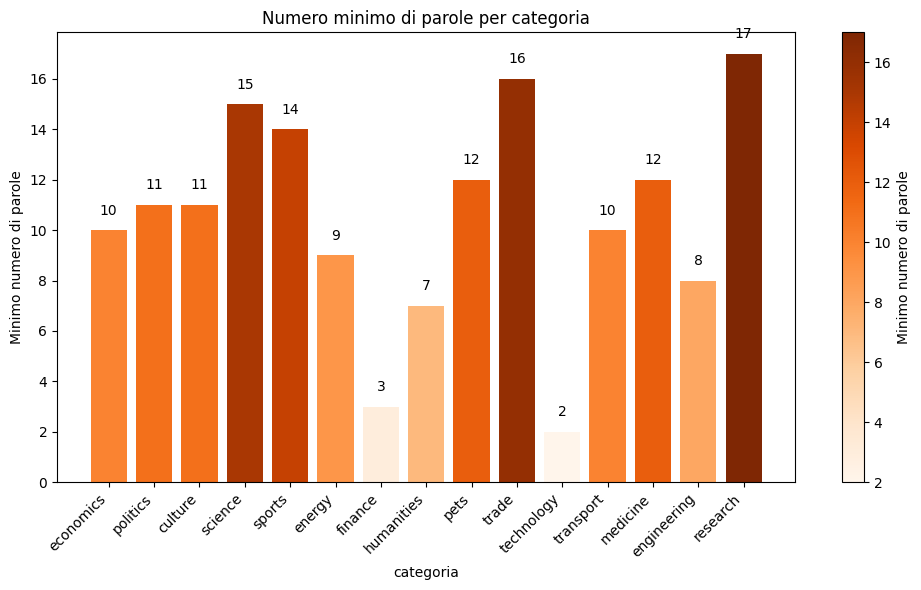

In [0]:
min_num_words = EDA_df.groupBy("categoria").agg(min(col("num_words")).alias("min_num_words"))

create_bar_chart(
    data=min_num_words,
    x_column='categoria',
    y_column='min_num_words',
    title='Numero minimo di parole per categoria',
    y_label='Minimo numero di parole'
)

Now for each category, we have to identify the most representative word cloud, to do this we will use the wordcloud library. First of all let us perform a minimum of text preprocessing to eliminate the stopwords.

In [0]:
EDA_df = EDA_df.withColumn("documents_array", split(col("documents"), " "))
remover = StopWordsRemover(inputCol="documents_array", outputCol="cleaned_documents")
df_cleaned = remover.transform(EDA_df)
df_cleaned = df_cleaned.withColumn("cleaned_documents", array_join("cleaned_documents", " "))
grouped_df = df_cleaned.groupBy("categoria").agg(concat_ws(" ", collect_list("cleaned_documents")).alias("merged_documents"))
categories = grouped_df.rdd.map(lambda x: x.categoria).collect()
category_texts = dict(grouped_df.select("categoria", "merged_documents").collect())

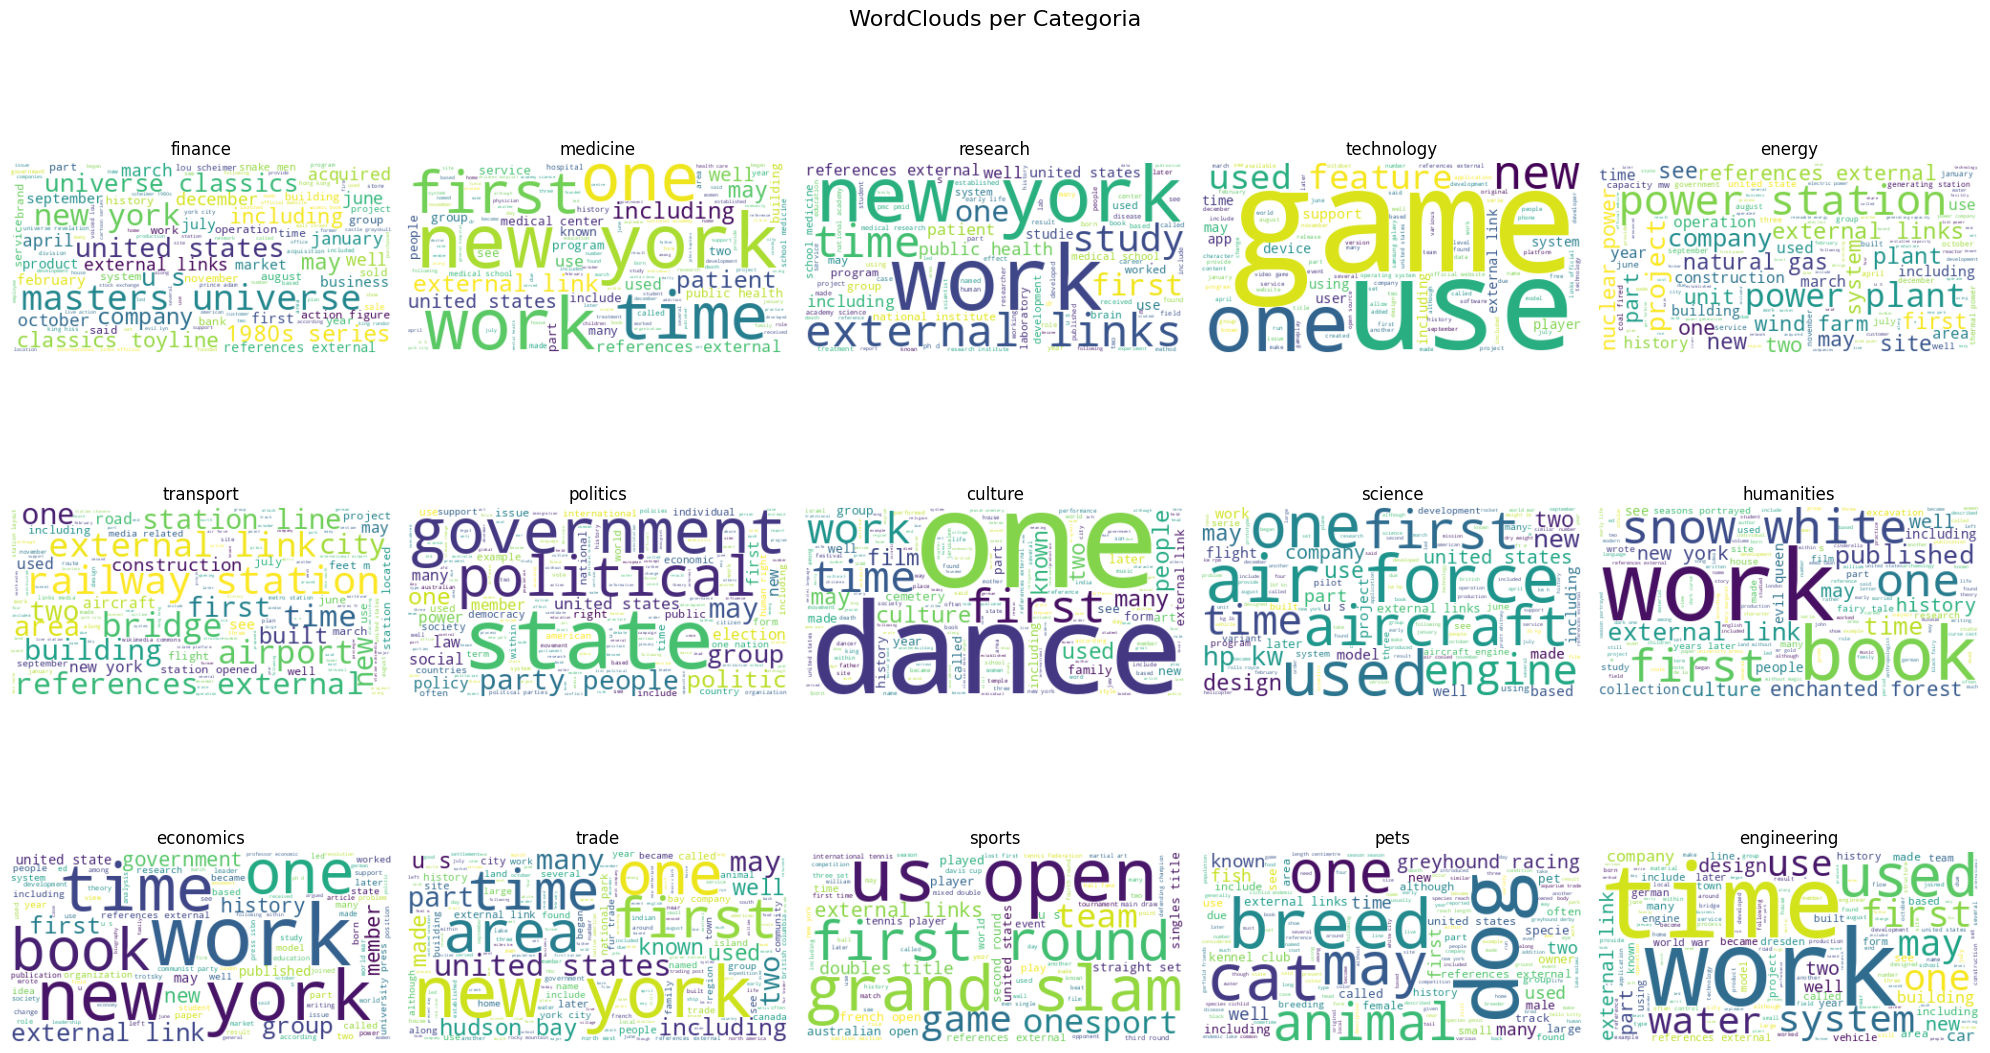

In [0]:
fig, axs = plt.subplots(3, 5, figsize=(20, 12))
fig.suptitle("WordClouds per Categoria", fontsize=16)
axs = axs.flatten()
for i, (categoria, testo) in enumerate(category_texts.items()):
    wordcloud = WordCloud(width=400, height=200, background_color="white").generate(testo)
    
    axs[i].imshow(wordcloud, interpolation="bilinear")
    axs[i].set_title(categoria)
    axs[i].axis("off")
for j in range(i+1, 15):
    fig.delaxes(axs[j])
plt.tight_layout()
plt.show()

# Classifier Model

We are being asked to train and test a textual classifier capable of classifying articles that will be included in the future, considering first the summary column, then the documents column, so as to compare the results obtained with the two different columns and test which of the two classifiers has greater accuracy in terms of classification. We are also going to compare two models, starting with a simple logistic regression and then moving to a multinomial Naive Bayes. We start by dividing the dataset into train set and test set.

In [0]:
(train_df, test_df) = spark_df.randomSplit([0.8, 0.2])

In order to be properly used as labels by our models, we create a numeric index for the categories.

In [0]:
indexer = StringIndexer(inputCol="categoria", outputCol="categoria_index")

indexer_model = indexer.fit(train_df)

train_df = indexer_model.transform(train_df)
test_df = indexer_model.transform(test_df)

We now proceed with text preprocessing to transform our summary and documents columns into features for our models. The steps contained in our pipeline, which we will perform separately for summary and documents, will be as follows:
- Tokenization
- Stopwords removal
- Vectorization
- IDF

In [0]:
tokenizer_summary = Tokenizer(inputCol="summary", outputCol="summary_tokens")
remover_summary = StopWordsRemover(inputCol="summary_tokens", outputCol="summary_filtered")
vectorizer_summary = CountVectorizer(inputCol="summary_filtered", outputCol="summary_raw_features")
idf_summary = IDF(inputCol="summary_raw_features", outputCol="summary_features")

pipeline_summary = Pipeline(stages=[
    tokenizer_summary,
    remover_summary,
    vectorizer_summary,
    idf_summary
])

tokenizer_docs = Tokenizer(inputCol="documents", outputCol="documents_tokens")
remover_docs = StopWordsRemover(inputCol="documents_tokens", outputCol="documents_filtered")
vectorizer_docs = CountVectorizer(inputCol="documents_filtered", outputCol="documents_raw_features")
idf_docs = IDF(inputCol="documents_raw_features", outputCol="documents_features")

pipeline_docs = Pipeline(stages=[
    tokenizer_docs,
    remover_docs,
    vectorizer_docs,
    idf_docs
])

We proceed to perform the fit and apply our pipeline on the train and test set.

In [0]:
pipeline_summary_model = pipeline_summary.fit(train_df)
train_summary_transformed = pipeline_summary_model.transform(train_df)
test_summary_transformed = pipeline_summary_model.transform(test_df)

pipeline_docs_model = pipeline_docs.fit(train_df)
train_docs_transformed = pipeline_docs_model.transform(train_df)
test_docs_transformed = pipeline_docs_model.transform(test_df)

## Logistic Regression

Now that we have our features and label column we initialize and train our models. We start with a logistic regression so we have a basic model to compare with more complex models. Since we are dealing with 15 different categories we will set the model to multinomial.

In [0]:
lr_summary = LogisticRegression(labelCol="categoria_index", featuresCol="summary_features", maxIter=10, family="multinomial")
lr_model_summary = lr_summary.fit(train_summary_transformed)

lr_documents = LogisticRegression(labelCol="categoria_index", featuresCol="documents_features", maxIter=10, family="multinomial")
lr_model_documents = lr_documents.fit(train_docs_transformed)

Once the model is trained we initialize our evaluator, as required by the trace the metric we will rely on is accuracy.

In [0]:
evaluator = MulticlassClassificationEvaluator(labelCol="categoria_index", predictionCol="prediction", metricName="accuracy")

We calculate predictions and accuracy for both summaries and documents.

In [0]:
lr_summary_predictions = lr_model_summary.transform(test_summary_transformed)
lr_accuracy_summary = evaluator.evaluate(lr_summary_predictions)

lr_docs_predictions = lr_model_documents.transform(test_docs_transformed)
lr_accuracy_docs = evaluator.evaluate(lr_docs_predictions)

We print the obtained accuracy on the screen.

In [0]:
print(f"Accuracy del modello lr_summary: {lr_accuracy_summary}")
print(f"Accuracy del modello lr_documents: {lr_accuracy_docs}")

Accuracy del modello lr_summary: 0.8248136666446805
Accuracy del modello lr_documents: 0.8551546731745927


With this model we get better classification results documents, that is the whole article.

## Naive Bayes
We continue with training the Naive Bayes model, I chose to use him over others since we are dealing with text classification and because of the little computational power required given the limitations of the community version of DataBricks. Again we will use a Multinomial NB to handle our 15 categories.

In [0]:
nb_summary = NaiveBayes(labelCol="categoria_index", featuresCol="summary_features", modelType="multinomial")
nb_model_summary = nb_summary.fit(train_summary_transformed)

nb_documents = NaiveBayes(labelCol="categoria_index", featuresCol="documents_features", modelType="multinomial")
nb_model_documents = nb_documents.fit(train_docs_transformed)

We calculate predictions and accuracy for both summaries and documents.

In [0]:
nb_summary_predictions = nb_model_summary.transform(test_summary_transformed)
nb_accuracy_summary = evaluator.evaluate(nb_summary_predictions)

nb_docs_predictions = nb_model_documents.transform(test_docs_transformed)
nb_accuracy_docs = evaluator.evaluate(nb_docs_predictions)

In [0]:
print(f"Accuracy del modello nb_summary: {nb_accuracy_summary}")
print(f"Accuracy del modello nb_documents: {nb_accuracy_docs}")

Accuracy del modello nb_summary: 0.8260668821317855
Accuracy del modello nb_documents: 0.8316733724688345


Again we get better accuracy with documents, however we obtained the best accuracy with logistic regression.